In [ ]:
!pip install pyecharts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
#from pyecharts import options as opts
#from pyecharts.charts import Graph
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from keras.preprocessing import sequence
from transformers import BertTokenizer, BertForSequenceClassification
!nvidia-smi
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Tue Dec 12 21:44:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
marked_sentence_df = pd.read_csv('/content/gdrive/My Drive/540_covid_knowledge_graph/marked_sentence.csv')

Mounted at /content/gdrive


In [ ]:
marked_sentence_df.sample(5)

,start_entity,end_entity,start_entity_type,end_entity_type,marked_sentence
31473,CCL5,CD4,Gene,Gene,"In vivo administration of CpG, PolyI:C and Pam..."
12339,CD4,CD68,Gene,Gene,"Microglia-specific cell surface molecules, inc..."
28534,ITCH,TRAF6,Gene,Gene,"Also, acting on mitochondria ORF-9b targets th..."
32484,C7orf49,Multiple Sclerosis,Gene,Disease,Although important information about the disea...
14466,Communicable Diseases,sputum,Disease,Disease,Pieters A151 Clinical significance between the...


In [ ]:
import networkx as nx
network_df = marked_sentence_df.iloc[:, :2]
network_df

,start_entity,end_entity
0,IGKV4-1,TAZ
1,keyhole limpet hemocyanin,"Lupus Erythematosus, Systemic"
2,COVID-19,Pharyngitis
3,cough,sputum
4,B3GAT1,GLS2
...,...,...
40807,Coronavirus Infections,Syndrome
40808,MERS,Severe Acute Respiratory Syndrome
40809,MERS,Syndrome
40810,Severe Acute Respiratory Syndrome,Syndrome


In [ ]:
G = nx.from_pandas_edgelist(network_df, source='start_entity',target='end_entity', create_using=nx.DiGraph())
print(G.number_of_edges())
print(G.number_of_nodes())
G.is_directed()
if nx.is_strongly_connected(G):
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"The average shortest path length is: {avg_shortest_path_length}")
else:
    print("The graph is not strongly connected.")
    # Find the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_scc)
    avg_shortest_path_length = nx.average_shortest_path_length(subgraph)
    print(f"The average shortest path length within the largest strongly connected component is: {avg_shortest_path_length}")
average_degree = sum([d for (n, d) in nx.degree(G)]) / float(G.number_of_nodes())
print(f"The average degree of the network is: {average_degree}")

20484
3644
The graph is not strongly connected.
The average shortest path length within the largest strongly connected component is: 0
The average degree of the network is: 11.242590559824368


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#G.to(device)
import random
num_sampled_nodes = 20
sampled_nodes = random.sample(G.nodes(), num_sampled_nodes)
H1 = G.subgraph(sampled_nodes)

num_sampled_edges = 20
sampled_edges = random.sample(G.edges(), num_sampled_edges)
H2 = nx.Graph()  # Create a new graph for the sampled edges
H2.add_edges_from(sampled_edges)

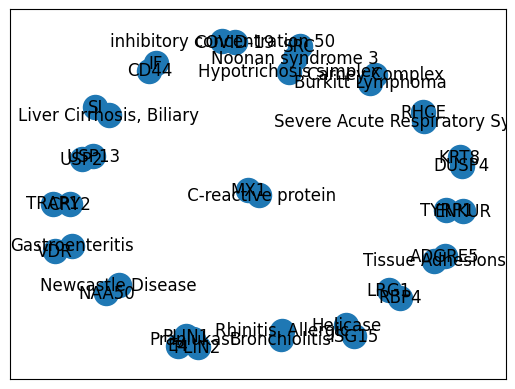

In [ ]:
nx.draw_networkx(H2)

In [ ]:
print(f"Transitivity of this graph is {nx.transitivity(G)}")
print(f"Average clustering coefficient is {nx.average_clustering(G)}")
print(f"Density of this graph is {nx.density(G)}")
print(f"Degree assortativity of this graph is {nx.degree_assortativity_coefficient(G)}")

Transitivity of this graph is 0.126725404221842
Average clustering coefficient is 0.2249793429442519
Density of this graph is 0.0015430401536953567
Degree assortativity of this graph is -0.07115315396733493


In [ ]:
mydict_pagerank = {k:v for (k, v) in sorted(nx.pagerank(G, alpha=0.5).items(), key= lambda t: t[1], reverse=True)}
print(list(mydict_pagerank.keys())[:10])

['COVID-19', 'Severe Acute Respiratory Syndrome', 'diarrhea', 'sputum', 'vomiting', 'cough', 'thrombocytopenia', 'Syndrome', 'Van der Woude syndrome', 'inhibitory concentration 50']


In [ ]:
mydict_avg_nei_deg = {k:v for (k, v) in sorted(nx.average_neighbor_degree(G).items(), key= lambda t: t[1], reverse=True)}
print(list(mydict_avg_nei_deg.keys())[:10])

['BTF3', 'CAMK2G', 'CYCSP39', 'FCER2', 'ENGASE', 'GAA', 'AFAP1L2', 'Emtricitabine', 'HBE1', 'GLDC']


In [ ]:
pageranks = nx.pagerank(G, weight='count')
pageranks = {k:v for k, v in sorted(pageranks.items(), key=lambda t: t[1], reverse=True)}
#pageranks

In [ ]:
highest_pagerank_diseases = list(pageranks.keys())[0:10]
count = 1
for disease in highest_pagerank_diseases:
    print("{}. {}".format(count, disease))
    count += 1

1. vomiting
2. sputum
3. Severe Acute Respiratory Syndrome
4. diarrhea
5. thrombocytopenia
6. treatment failure
7. COVID-19
8. cough
9. Syndrome
10. Van der Woude syndrome


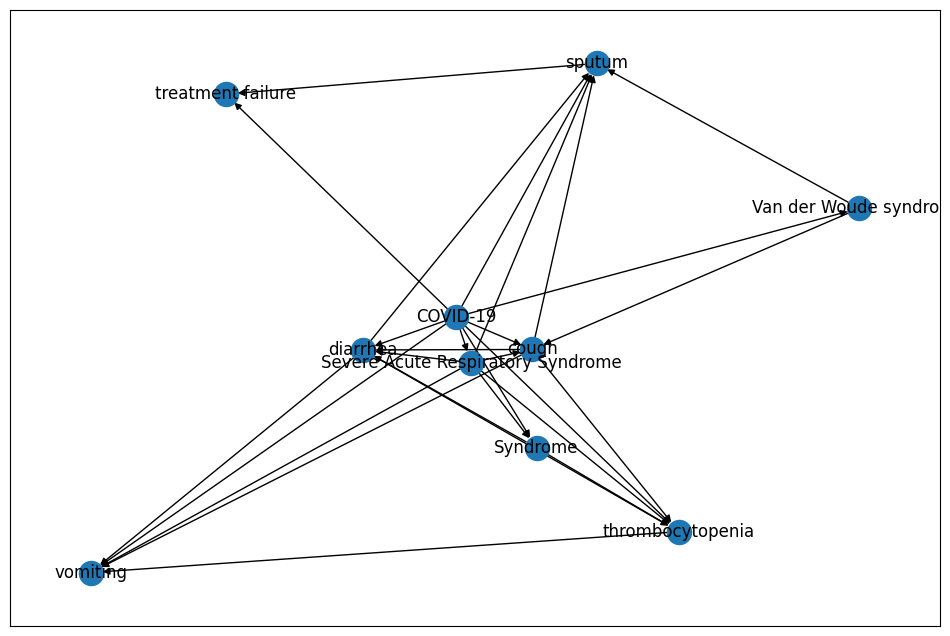

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
top10 = G.subgraph(highest_pagerank_diseases)
nx.spring_layout(top10)
nx.draw_networkx(top10)

In [ ]:
lowest_pagerank_diseases = list(pageranks.keys())[-10:]
count = 1
for disease in lowest_pagerank_diseases:
    print("{}. {}".format(count, disease))
    count += 1

1. AQP3
2. PLXNA2
3. HDAC1
4. DNAI1
5. Amodiaquine
6. RASL12
7. ANTXR1
8. FSCN1
9. BMP7
10. EPS15


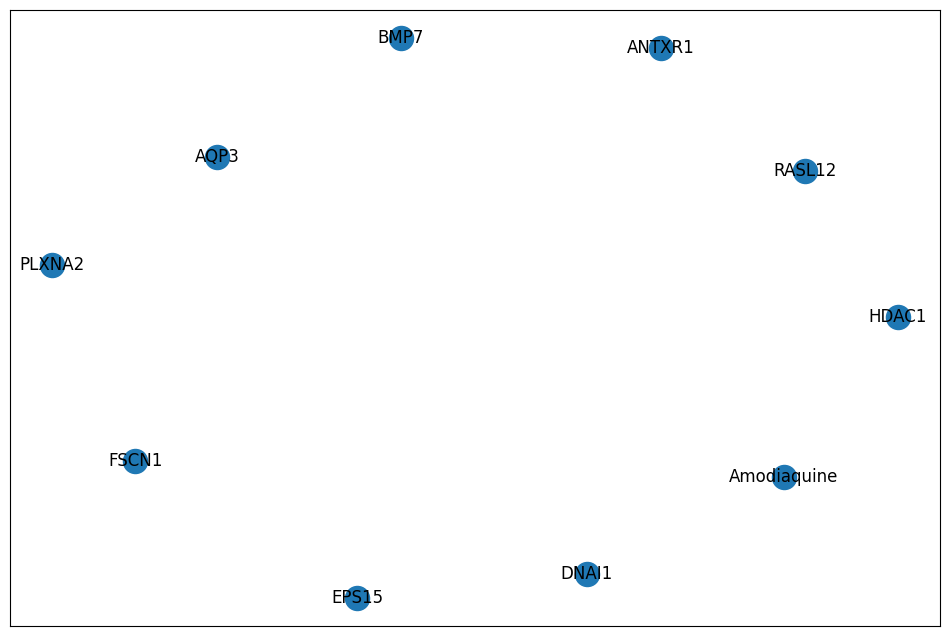

In [ ]:
plt.figure(figsize=(12,8))
bottom10 = G.subgraph(lowest_pagerank_diseases)
nx.draw_networkx(bottom10)

In [ ]:
# check for dead-ends in our network
set(network_df.start_entity) == set(network_df.end_entity)

False

<Axes: >

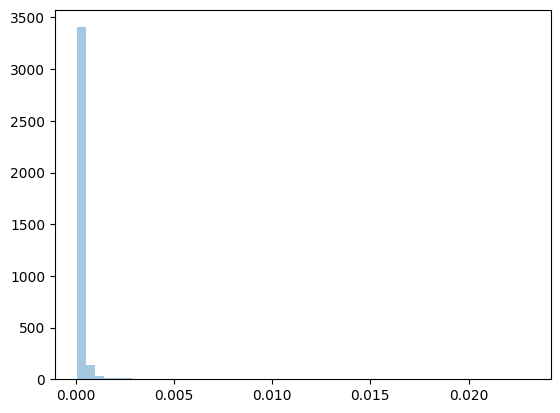

In [ ]:
import seaborn as sns
# check for spider traps: is any node/group of nodes "trapping" importance?

# plot distribution of PageRank values
sns.distplot(list(pageranks.values()), kde=False)

In [ ]:
# the full network - this will serve as our 'test' data

G = nx.from_pandas_edgelist(network_df, "start_entity", "end_entity", create_using=nx.Graph()) # undirected
print("Numer of diseases in the network:", G.number_of_nodes()) # check
print("Number of mutual likes:", G.number_of_edges()) # check

Numer of diseases in the network: 3644
Number of mutual links: 20484


In [ ]:
# what edges can be dropped but will not drop the node from the network or create an unconnected network?

# source: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

initial_node_count = len(G.nodes) # how many nodes are in our full network? want to preserve this #!

network_df_temp = network_df.copy()

removable_edges_idx = []



for i in network_df.index.values: # loop through all edges in our data

    # remove the edge from the data and build a new graph without it
    G_temp = nx.from_pandas_edgelist(network_df_temp.drop(index = i), "start_entity", "end_entity", create_using=nx.Graph())

    # check if there is fragmentation in the graph or if the number of nodes in the network changed
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        removable_edges_idx.append(i)
        network_df_temp = network_df_temp.drop(index = i)


len(removable_edges_idx) # number of edges we CAN drop

TypeError: ignored

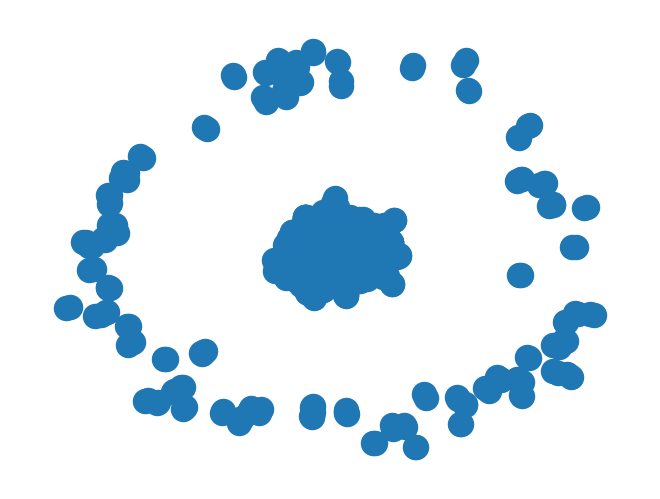

In [ ]:
nx.draw(G_temp)